In [1]:
import numpy as np
import pandas as pd
import pygimli as pg
from pygimli.physics import ert
import matplotlib.pyplot as plt


In [2]:
# load data file (already in BERT unified data format)

data_in = ert.load('data_unified/fieldschool_wen3_2013_aug26.txt') # data from UofCalgary 2013 geophysics field school. bad electrode

print(data_in)

Data: Sensors: 72 data: 810, nonzero entries: ['a', 'b', 'err', 'i', 'm', 'n', 'r', 'u', 'valid']


In [3]:
# calculate geometric factor and apparent resistivity if not already in data file

if max(data_in['k'])==0:
    data_in['k'] = ert.createGeometricFactors(data_in)

if max(data_in['rhoa'])==0:
    data_in['rhoa'] = (data_in['u']/data_in['i'])*data_in['k']

05/06/21 - 02:02:36 - pyGIMLi - INFO - Cache /Users/teddiherringnew/anaconda/envs/idgsp/lib/python3.8/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (0.0s x 3): /Users/teddiherringnew/Library/Caches/pygimli/9979849352437500661


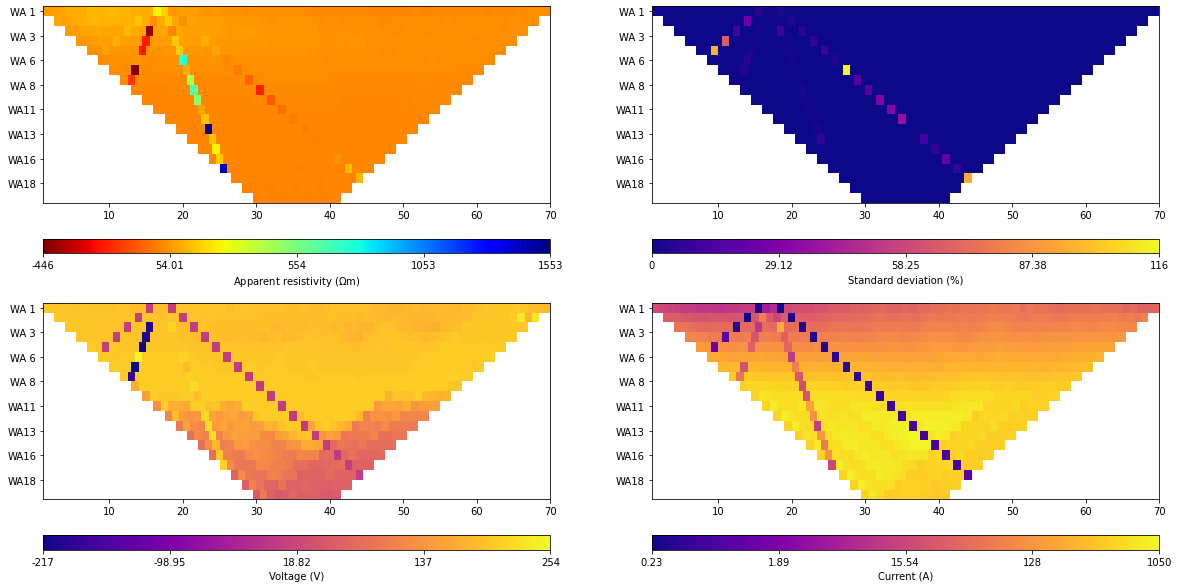

In [4]:
# plot raw data 

mgr = ert.ERTManager(data_in)

fig, ax = plt.subplots(2,2,figsize=[20,10])

mgr.showData(data_in, vals=data_in['rhoa'],ax=ax[0,0],label=r'Apparent resistivity ($\Omega$m)',cMap='jet_r');

if max(data_in['err']>0):
    mgr.showData(data_in, vals=data_in['err'],ax=ax[0,1],label='Standard deviation (%)',cMap='plasma');
else:
    ax[0,1].text(0.35,0.5,'no err data available',fontsize=16)
    
if max(data_in['u']>0):    
    mgr.showData(data_in, vals=data_in['u'],ax=ax[1,0],label='Voltage (V)',cMap='plasma');
else:
    ax[1,0].text(0.35,0.5,'no voltage data available',fontsize=16)
    
if max(data_in['i']>0):
    mgr.showData(data_in, vals=data_in['i'],ax=ax[1,1],label='Current (A)',cMap='plasma');
else:
    ax[1,1].text(0.35,0.5,'no current data available',fontsize=16)

In [5]:
# to apply a moving median filter we will need to sort our data by depth level and array midpoint. 


# 1. put data into DataFrame (although there is probably a better way to do this)

df = pd.DataFrame(np.array(data_in.dataMap()).T)
header = df.iloc[0]
df = df[1:] 
df.columns = header
df = df.apply(pd.Series.explode).reset_index()



# 2. find midpoint of array

mp = []
for i in range(len(data_in['a'])):
    mp.append(np.mean([
    data_in.sensors()[data_in['a']][i][0],
    data_in.sensors()[data_in['b']][i][0],
    data_in.sensors()[data_in['m']][i][0],
    data_in.sensors()[data_in['n']][i][0],
]))
    
mp = np.array(mp)


# 3. sort by depth level and midpoint so we can apply moving median filter
# note: this works for 2D lines with topography

def sort_data(data,a,x,plotit=True):

    # to find unique depth levels, check to find unique relative positions of electrodes
    ab = data['a'] - data['b']
    am = data['a'] - data['m']
    an = data['a'] - data['n']
    
    a = (np.array([ab,am,an]).T).astype(dtype=float)

    a_uniq = np.unique(a, axis=0)
    
    # sort by depth level
    sort_index = np.argsort(a)
    i_all = np.linspace(0,len(a),len(a)+1).astype('int')
    sort_index = np.array([])

    # sort by midpoint
    for i in range(len(a_uniq)):
            j = np.where((a==a_uniq[i]).all(axis=1))
            si = np.argsort(x[j])
            sort_index = np.append(sort_index,i_all[j][si]) 

    sort_index = sort_index.astype('int')
    data_sort = pd.DataFrame(data,index=sort_index)

    return(data_sort)


# ... and sort!

data_sort = sort_data(df,df['k'],mp)

<ipython-input-5-61bf9675b431>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df = pd.DataFrame(np.array(data_in.dataMap()).T)


In [6]:
# this is the part where we filter the data

data_filt = data_sort.copy()



# step 1. technical filter

# here we are just keeping track of how many data points are removed
n_tf = (len(np.unique(np.hstack([ 
    np.where(data_filt['rhoa'] < 0)[0],
    np.where(data_filt['err'] > 10)[0],
    np.where(data_filt['rhoa'] > 7*np.std(data_filt['rhoa']))[0]
]))))

data_filt = data_filt[data_filt['rhoa'] > 0]
data_filt = data_filt[data_filt['err'] < 10]
data_filt = data_filt[data_filt['rhoa'] < 7*np.std(data_filt['rhoa'])]



# step 2. moving median filter

th = 0.5 # threshold for filter
n_mmf = 0 # keeping track of how many data are removed

ikeep = np.ones(data_filt.shape[0],dtype=bool)


for j in range(len(np.unique(data_filt['k']))): # loop through each unique depth level
    
    I = np.where(data_filt['k']==np.unique(data_filt['k'])[j])[0]
    
    # moving median of data points
    
    mm = [] 
    r = np.array(data_filt['rhoa'])[I]
   
    for i in range(len(I)): # loop through depth level from left to right
        if i==0:
            mm.append(np.median(r[i:2])) # end points only use one neighboring data point to calculate median
        elif i==len(r)-1:
            mm.append(np.median(r[i-1:])) 
        else:
            mm.append(np.median(r[i-1:i+2])) 
    
    ithrow = np.where(abs(r-mm)/mm > th)[0]
    n_mmf = n_mmf + len(ithrow)
    
    for i in range(len(ithrow)):
        ikeep[I[ithrow[i]]] = 0

print('data points removed by technical filter = %.0f'%n_tf)
print('data points removed by moving median filter = %.0f'%n_mmf)

data_filt = data_filt[ikeep]

data points removed by technical filter = 24
data points removed by moving median filter = 16


In [7]:
# put everything back into the data container

data_out = pg.DataContainerERT()

# sensors are the same
for i in range(0,len(data_in.sensors())):
    data_out.createSensor(np.array(data_in.sensors()[i])) # 2D, no topography

# add filtered quadripoles and data 
cols = data_filt.columns
for i in range(len(cols)):
    if max(data_filt[cols[i]]) > 0:
        data_out[cols[i]] = np.array(data_filt[cols[i]])

40 data points removed (4.9% of the data)


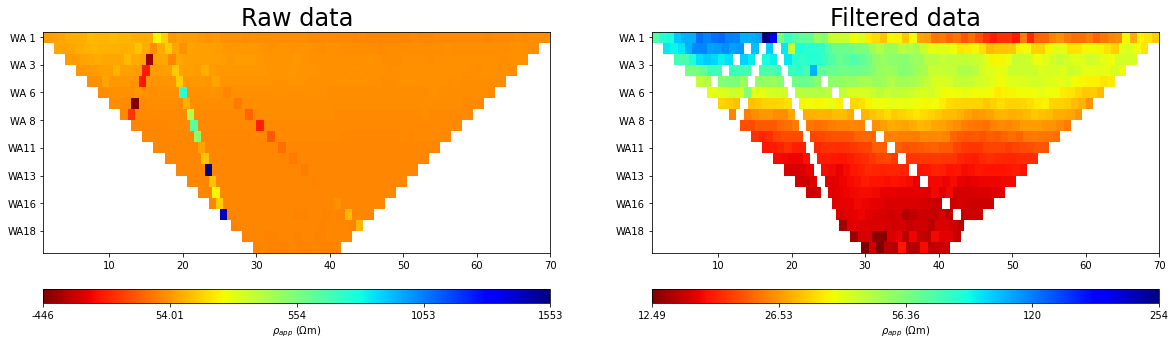

In [8]:
# plot filtered data

fig, ax = plt.subplots(1,2,figsize=[20,5])

d = data_in
mgr.showData(d, vals=d['rhoa'],ax=ax[0],label=r'$\rho_{app}$ ($\Omega$m)',cMap='jet_r');
ax[0].set_title('Raw data',fontsize=24);

d = data_out
mgr.showData(d, vals=d['rhoa'],ax=ax[1],label=r'$\rho_{app}$ ($\Omega$m)',cMap='jet_r');
ax[1].set_title('Filtered data',fontsize=24);

print('%.0f data points removed (%.1f%% of the data)'%(n_tf+n_mmf, float((data_in.size()-data_out.size())/data_in.size()*100)))

In [9]:
# first pass inversion

# assume simple noise model for now

data_out['err'] = ert.estimateError(
    data_out, 
    absoluteUError=0.00005, # 50µV
    relativeError=0.03 # 3% noise
)  

# run inversion

mod = mgr.invert(
    data_out,
    blockymodel=True, 
    robustdata=True,
    verbose=True, 
#     lam = 20, # can change regularization parameter
#     paraMaxCellSize=10, # can change the maximum cell area
#     paraDX=0.3 # can change the ratio of smoothness_x / smoothness_z
)

05/06/21 - 02:02:40 - pyGIMLi - INFO - Found 2 regions.
05/06/21 - 02:02:40 - pyGIMLi - INFO - Region with smallest marker (1) set to background
05/06/21 - 02:02:40 - pyGIMLi - INFO - Creating forward mesh from region infos.
05/06/21 - 02:02:40 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
05/06/21 - 02:02:40 - Core - WARNING - Region Nr: 1  is background and should not get a model control.
05/06/21 - 02:02:40 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
05/06/21 - 02:02:40 - pyGIMLi - INFO - Starting inversion.
05/06/21 - 02:02:40 - pyGIMLi - INFO - Set default startmodel to median(data values)=29.932034830478344
05/06/21 - 02:02:40 - pyGIMLi - INFO - Created startmodel from forward operator: 1207 [29.932034830478344,...,29.932034830478344]


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x15d28bea0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x15d28bf90>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x15d28bf40>
min/max (data): 12.49/254
min/max (error): 3.00%/3.05%
min/max (start model): 29.93/29.93
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 7.8 (dPhi = 43.93%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 3.92 (dPhi = 32.8%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 3.88 (dPhi = 0.76%) lam: 20.0
################################################################################
#                 Abort criteria reached: dPhi = 0.76 (< 2.0%)                 #
##############################################

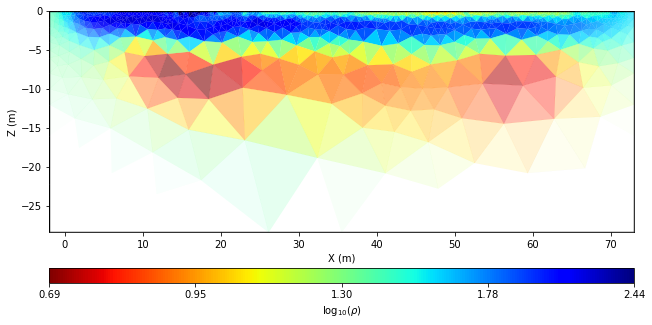

In [10]:
# plot results

fig, ax = plt.subplots(1,1,figsize=[20,5])

ax, cBar = mgr.showModel(
    np.log10(mod),
    ax=ax,
    cMap='jet_r',
    coverage=mgr.coverage()

);

cBar.set_label(r'log$_{10}$($\rho$)')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)');
